## Imports and constants

In [2]:
%matplotlib ipympl
# %matplotlib inline

import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
# os.chdir("/Users/angelax/ownCloud/Documents/University/atoms_and_water/onix")
# os.environ["DATAFOLDER"] = "/Users/angelax/ownCloud/Documents/University/atoms_and_water/data"
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.helpers import data_identifier, console_bold, present_float


In [3]:
name = "Transmission"
analysis_number = None
identifier = None

In [4]:
def average_error(error_array):
    try:
        error = np.divide(1, np.sum(np.divide(1, np.power(error_array, 2))))
    except ZeroDivisionError:
        error = 0
    return error

def weight_average(data_array, error_array, bin_indices):
    assert len(data_array) == len(bin_indices) and len(data_array) == len(error_array), "Arrays should be same length."
    try:
        mean = np.divide(np.sum(np.divide(data_array,np.power(error_array, 2)),
                      np.sum(np.divide(1, np.power(error_array, 2)))))
    except ZeroDivisionError:
        error = 0
    return error

In [5]:
class TransmissionRun:
    """ A class that processes raw data for a transmission run.

    Instance attributes:
        - 
        - 
    """
    
    def __init__(self, data_and_header, V_low_bound, V_high_bound, frequency_jump_threshold_GHz=0.1):
        self._data, self._header = data_and_header
        self._average_datapoints()
        self._filter_invalid_voltage(V_low_bound, V_high_bound)
        # self._filter_frequency_jumps(frequency_jump_threshold_GHz)
        self._filter_multi_mode()
        self._filter_large_error()
        self.mode_error_mask = np.bitwise_and(self.single_mode_mask, self.large_error_mask)
        # self.V_mode_and_freq_jump_mask = np.bitwise_and(self.mode_error_mask, np.bitwise_and(self.invalid_V_mask, self.frequency_jump_mask))
        self.V_mode_and_valid_freq_mask = np.bitwise_and(self.mode_error_mask, self.invalid_V_mask)
        self._get_valid_frequency_range()
        self.V_mode_and_valid_freq_mask = np.bitwise_and(self.mode_error_mask, np.bitwise_and(self.invalid_V_mask, self.valid_freq_mask))


    def _average_datapoints(self):
        self.time = self._data["times"]
        self.frequency_GHz = self._data["frequency_after_GHz"]
        self.V_transmission = np.average(self._data["V_transmission"], axis=1)
        self.V_transmission_err = np.divide(np.std(self._data["V_transmission"], axis=1, ddof=1),
                                            np.sqrt(len(self._data["V_transmission"][0])))
        self.V_monitor = np.average(self._data["V_monitor"], axis=1)
        self.V_monitor_err = np.divide(np.std(self._data["V_monitor"], axis=1, ddof=1),
                                       np.sqrt(len(self._data["V_monitor"][0])))
        self.V_ratio = self.V_transmission / self.V_monitor
        self.V_ratio_err = np.multiply(self.V_ratio, np.sqrt(
            np.power(np.divide(self.V_monitor_err, self.V_monitor), 2) 
            + np.power(np.divide(self.V_transmission_err, self.V_transmission), 2)))

    def _get_valid_frequency_range(self):
        self.valid_freq_mask = self.frequency_GHz > 0
        valid_freqs = self.frequency_GHz[np.bitwise_and(self.valid_freq_mask, self.V_mode_and_valid_freq_mask)]
        self.valid_frequency_range_GHz = (np.min(valid_freqs), np.max(valid_freqs))

    def _filter_frequency_jumps(self, frequency_jump_threshold_GHz):
        freq_differences = np.abs(np.ediff1d(self.frequency_GHz))
        below_threshold_next = freq_differences < frequency_jump_threshold_GHz
        below_threshold_previous = np.roll(below_threshold_next, shift=1)
        mask = np.bitwise_and(below_threshold_next, below_threshold_previous)
        mask = np.append(mask, False)
        mask[0] = False
        self.frequency_jump_mask = np.bitwise_and(mask, self.valid_freq_mask)

    def _filter_multi_mode(self, contrast_bound = 0.9):
        self.contrast = self._data["contrast_after"]
        self.single_mode_mask = self.contrast > contrast_bound
    
    def _filter_invalid_voltage(self, low_bound_V, high_bound_V):
        above_low_bound = np.bitwise_and(np.abs(self.V_transmission)>low_bound_V, np.abs(self.V_monitor)>low_bound_V)
        below_high_bound = np.bitwise_and(np.abs(self.V_transmission)<high_bound_V, np.abs(self.V_monitor)<high_bound_V)
        self.invalid_V_mask = np.bitwise_and(above_low_bound, below_high_bound)

    def _filter_large_error(self):
        self.large_error_mask = self.V_ratio_err < ((np.max(self.V_ratio[self.invalid_V_mask])-np.min(self.V_ratio[self.invalid_V_mask]))/6)
        
    def bin_data(self, bin_width_GHz = 5):
        mask = self.V_mode_and_valid_freq_mask
        num_bins = int((self.valid_frequency_range_GHz[1] - self.valid_frequency_range_GHz[0]) / bin_width_GHz)

        if num_bins == 0:
            num_bins = 1
        print(num_bins)
        bins = np.linspace(
            self.valid_frequency_range_GHz[0], 
            self.valid_frequency_range_GHz[1], 
            num_bins, endpoint = True
        )
        bin_index = np.digitize(self.frequency_GHz[mask], bins)
        for kk in range(len(bins) + 1):
            mask1 = bin_index == kk
            
        
        means, bin_edges, binnumber = st.binned_statistic(
            self.frequency_GHz[mask], self.V_ratio[mask], statistic="mean", bins=num_bins
        )
        stds, bin_edges, binnumber = st.binned_statistic(
            self.frequency_GHz[mask], self.V_ratio_err[mask], statistic=average_error, bins=num_bins
        )
        
        occurrences = np.bincount(binnumber)[1:]
        self.V_ratio_binned_avg = means
        self.V_ratio_binned_err = stds / np.sqrt(occurrences)
        self.frequency_binned = bin_edges[1:] - bin_edges[1] + bin_edges[0]

In [6]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

## Setup

In [12]:
data_numbers = [100574]
frequency_jump_threshold_GHz = 5
V_low_bound = 0
V_high_bound = 100
data = dict([(
    kk,
    TransmissionRun(get_experiment_data(kk), V_low_bound, V_high_bound, frequency_jump_threshold_GHz)
) for kk in data_numbers])

In [13]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

Create new analysis folder? (y/n)  y


Current analysis number is 605


## Initial plot

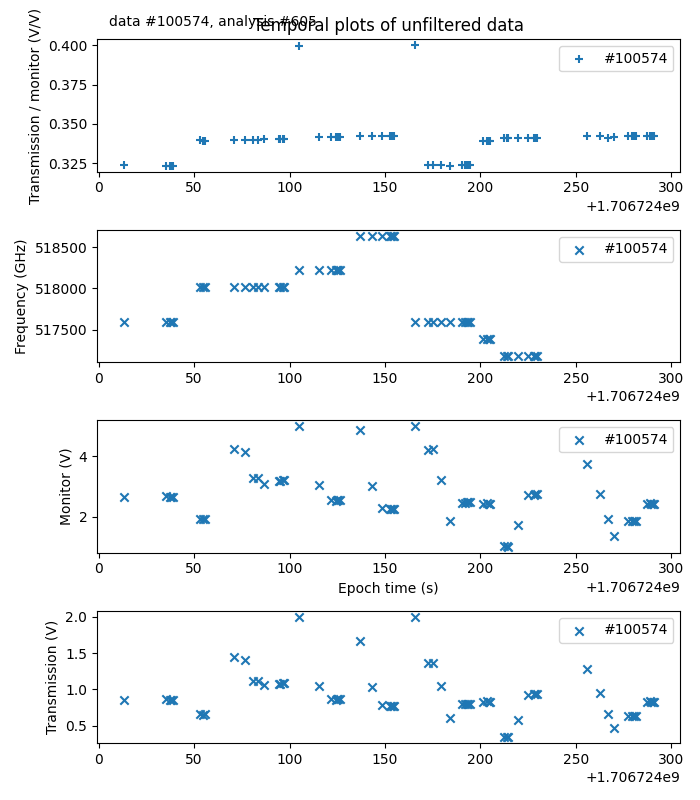

In [14]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(7, 8))
add_label(ax)
ax2.set_xlabel("Epoch time (s)")
ax.set_ylabel("Transmission / monitor (V/V)")
ax1.set_ylabel("Frequency (GHz)")
ax2.set_ylabel("Monitor (V)")
ax3.set_ylabel("Transmission (V)")
ax.set_title("Temporal plots of unfiltered data")
f_min = np.infty
f_max = -np.infty

for kk in data_numbers:
    run = data[kk]
    ax.scatter(run.time, run.V_ratio, marker="+", label=f"#{kk}")
    ax1.scatter(run.time, run.frequency_GHz, marker="x", label=f"#{kk}")
    ax2.scatter(run.time, run.V_monitor, marker="x", label=f"#{kk}")
    ax3.scatter(run.time, run.V_transmission, marker="x", label=f"#{kk}")
    if run.valid_frequency_range_GHz[0] < f_min:
        f_min = run.valid_frequency_range_GHz[0]
    if run.valid_frequency_range_GHz[1] > f_max:
        f_max = run.valid_frequency_range_GHz[1]
spacing = 0.05 * (f_max - f_min)
f_min -= spacing
f_max += spacing
ax1.set_ylim(f_min, f_max)
# ax.set_xlim(22700+1.7067e9, 23200+1.7067e9)
# ax2.set_ylim(0.3, 0.35)
# ax3.set_ylim(0.6, 0.7)

#ax.set_xlim(2000+ 1.71207e9,6000+1.71207e9)
#ax.set_ylim(0.20375, 0.2060)
#ax1.set_xlim(59800+1.7071e9)
#ax2.set_xlim(59800+1.7071e9)
#ax3.set_xlim(59800+1.7071e9)

ax.legend()
ax1.legend()
ax2.legend()
ax3.legend()
plt.tight_layout()

plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_temporal.pdf")
)
plt.show()

## Voltage ratio plot

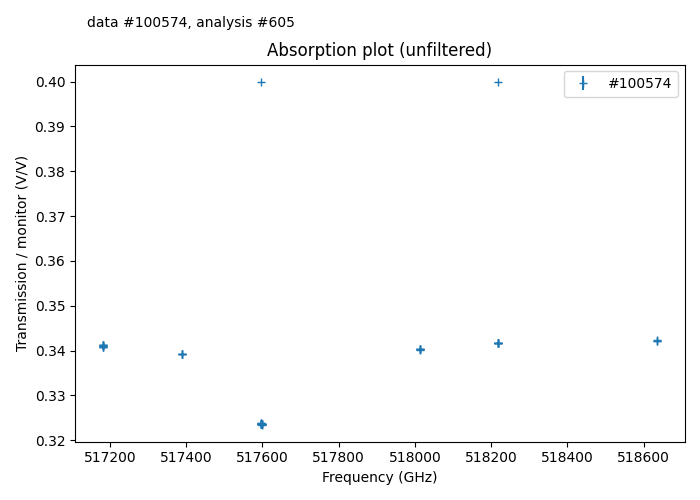

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
add_label(ax)
ax.set_ylabel("Transmission / monitor (V/V)")
ax.set_xlabel("Frequency (GHz)")
ax.set_title("Absorption plot (unfiltered)")
for kk in data_numbers:
    run = data[kk]
    ax.errorbar(
        run.frequency_GHz[run.V_mode_and_valid_freq_mask],
        run.V_ratio[run.V_mode_and_valid_freq_mask],
        run.V_ratio_err[run.V_mode_and_valid_freq_mask],
        marker="+", ls="none", label=f"#{kk}"
    )

ax.legend()
# ax.set_ylim(1.95, 2.16)
# ax.set_xlim(517550, 517760)

plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_unfiltered_V_ratio.pdf")
)
plt.show()

## Frequency jump filtered voltage ratio

AttributeError: 'TransmissionRun' object has no attribute 'V_mode_and_freq_jump_mask'

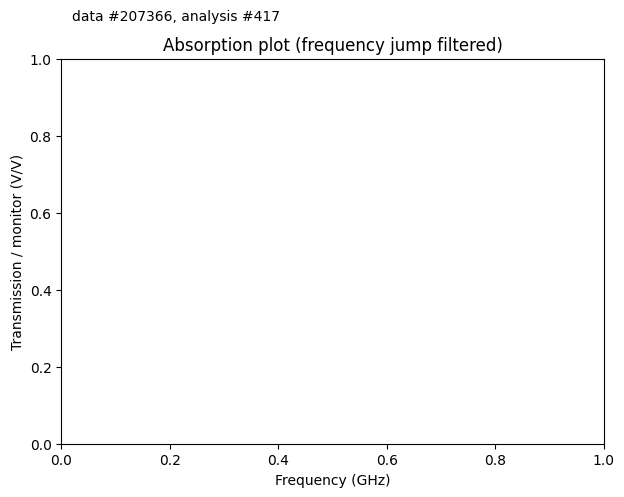

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
add_label(ax)
ax.set_ylabel("Transmission / monitor (V/V)")
ax.set_xlabel("Frequency (GHz)")
ax.set_title("Absorption plot (frequency jump filtered)")
for kk in data_numbers:
    run = data[kk]
    ax.scatter(
        run.frequency_GHz[run.V_mode_and_freq_jump_mask],
        run.V_ratio[run.V_mode_and_freq_jump_mask],
        marker="+",label=f"#{kk}"
    )
ax.legend()
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_jump_filtered_V_ratio.pdf")
)
plt.show()

## Binned plot

20


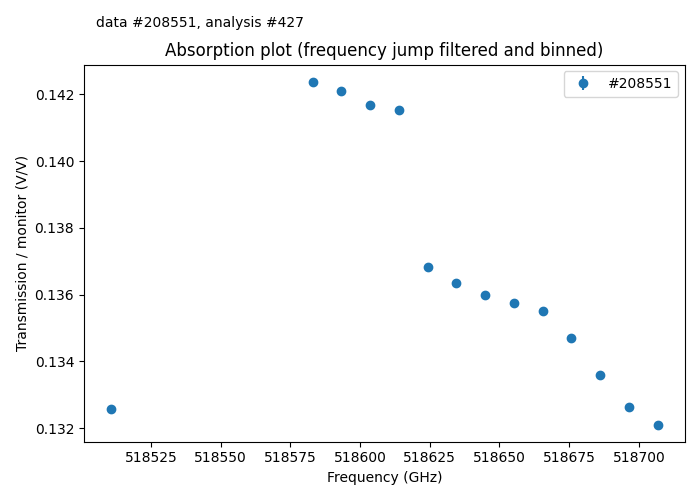

In [116]:
bin_size = 10
for kk in data_numbers:
    data[kk].bin_data(bin_width_GHz = bin_size)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
add_label(ax)
ax.set_ylabel("Transmission / monitor (V/V)")

ax.set_xlabel("Frequency (GHz)")
ax.set_title("Absorption plot (frequency jump filtered and binned)")
for kk in data_numbers:
    run = data[kk]
    ax.errorbar(
        run.frequency_binned,
        run.V_ratio_binned_avg,
        run.V_ratio_binned_err,
        marker="o", label=f"#{kk}", ls="none",
    )
ax.legend()
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_binned_V_ratio.pdf")
)
# plt.xlim([517500, 517800])
plt.show()

## Multiple Samples

In [47]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

Create new analysis folder? (y/n)  n
Keep current analysis number of 364? (y/n)  


Current analysis number is 364


### Multiple Transmission Class

In [46]:
class MultipleTransmissionRuns:
    """ A class that takes multiple transmission runs and connects them into one data set to do analysis.
    """
    num_transmission_runs: int
    V_ratio: np.ndarray
    V_ratio_err: np.ndarray
    frequency_GHz: np.ndarray
    valid_freq_mask: np.ndarray
    invalid_V_mask: np.ndarray
    V_mode_and_valid_freq_mask: np.ndarray
    V_ratio_binned_avg: np.ndarray
    V_ratio_binned_err: np.ndarray
    frequency_binned: np.ndarray
    
    def __init__(self, list_data_numbers, V_low_bound, V_high_bound, bin_width_GHz=5):
        self.num_transmission_runs = len(list_data_numbers)
        data = dict([(
            kk,
            TransmissionRun(get_experiment_data(kk), V_low_bound, V_high_bound)
            ) for kk in data_numbers])        

        attribute_list = ['V_ratio', 'V_ratio_err', 'frequency_GHz', 'valid_freq_mask', 'invalid_V_mask', 'V_mode_and_valid_freq_mask']
        
        for attribute in attribute_list:
            setattr(self,attribute,np.array([]))
        print(self.V_ratio)
        
        self.valid_frequency_range_GHz = (0,0)
        for kk in data_numbers:
            run = data[kk]
            print(kk)
            for attribute in attribute_list:
                setattr(self,attribute,np.array([]))

                self.attribute = np.concatenate((self.attribute, run.attribute))
            self.valid_frequency_range_GHz = (min(self.valid_frequency_range_GHz[0], run.valid_frequency_range_GHz[0]), 
                                              max(self.valid_frequency_range_GHz[1], run.valid_frequency_range_GHz[0]))

        self._rebin_data(bin_width_GHz)
        
            
    def _rebin_data(self, bin_width_GHz):
        mask = self.V_mode_and_valid_freq_mask
        num_bins = int((self.valid_frequency_range_GHz[1] - self.valid_frequency_range_GHz[0]) / bin_width_GHz)

        if num_bins == 0:
            num_bins = 1
        print(num_bins)
        bins = np.linspace(
            self.valid_frequency_range_GHz[0], 
            self.valid_frequency_range_GHz[1], 
            num_bins, endpoint = True
        )
        bin_index = np.digitize(self.frequency_GHz[mask], bins)
        for kk in range(len(bins) + 1):
            mask1 = bin_index == kk
        
        means, bin_edges, binnumber = st.binned_statistic(
            self.frequency_GHz[mask], self.V_ratio[mask], statistic="mean", bins=num_bins
        )
        stds, bin_edges, binnumber = st.binned_statistic(
            self.frequency_GHz[mask], self.V_ratio_err[mask], statistic=average_error, bins=num_bins
        )
        
        occurrences = np.bincount(binnumber)[1:]
        self.V_ratio_binned_avg = means
        self.V_ratio_binned_err = stds / np.sqrt(occurrences)
        self.frequency_binned = bin_edges[1:] - bin_edges[1] + bin_edges[0]
    
    # def plot_runs(self):
    #     fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    #     add_label(ax)
    #     ax.set_ylabel("Transmission / monitor (V/V)")
    #     ax.set_xlabel("Frequency (GHz)")
    #     ax.set_title(f"Absorption plot ({self.num_transmission_runs} runs together binned)")
    #     ax.errorbar(
    #         self.frequency[self.V_and_valid_freq_mask],
    #         self.V_ratio[self.V_and_valid_freq_mask],
    #         self.V_ratio_err[self.V_and_valid_freq_mask],
    #         marker="o", ls="none",
    #     )
    #     plt.tight_layout()
    #     plt.show()
        
test_multiple = MultipleTransmissionRuns(data_numbers, 0.4, 3.5)

[]
207432


AttributeError: 'MultipleTransmissionRuns' object has no attribute 'attribute'

### Concatenating multiple datasets

In [13]:
frequency_GHz = np.array([])
V_ratio = np.array([])
V_ratio_err = np.array([])
for kk in data_numbers:
    run = data[kk]
    frequency_GHz = np.concatenate((frequency_GHz, run.frequency_GHz[run.V_mode_and_valid_freq_mask]))
    V_ratio = np.concatenate((V_ratio, run.V_ratio[run.V_mode_and_valid_freq_mask]))
    V_ratio_err = np.concatenate((V_ratio_err, run.V_ratio_err[run.V_mode_and_valid_freq_mask]))

### Plotting concatenated data set

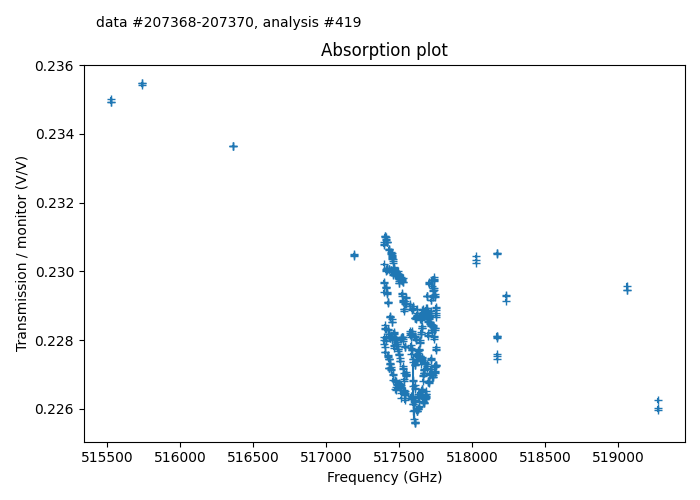

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
add_label(ax)
ax.set_ylabel("Transmission / monitor (V/V)")

ax.set_xlabel("Frequency (GHz)")
ax.set_title("Absorption plot")
ax.errorbar(
    frequency_GHz,
    V_ratio,
    V_ratio_err,
    marker="+", ls="none",
)
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_absorption_plot.pdf")
)
plt.show()

## Binning concatenated data

## Fitting functions

In [101]:
from scipy.optimize import curve_fit  # curve_fit is a nonlinear least-squares fit routine
from matplotlib import rc

def gauss_lin(x, a_1, x0_1, sigma_1, b, H):
    return a_1 * np.exp((-(x - x0_1) ** 2) / (2 * sigma_1 ** 2)) + b * x + H
    
def gauss(x, a_1, x0_1, sigma_1, H):
    return a_1 * np.exp((-(x - x0_1) ** 2) / (2 * sigma_1 ** 2)) + H
    
def double_gaussian_lin(x, a_1, x0_1, sigma_1, a_2, x0_2, sigma_2, b, H):
    return a_1 * np.exp((-(x - x0_1) ** 2) / (2 * sigma_1 ** 2)) + a_2 * np.exp(
        (-(x - x0_2) ** 2) / (2 * sigma_2 ** 2)) + b * x + H

def double_gaussian(x, a_1, x0_1, sigma_1, a_2, x0_2, sigma_2, H):
    return a_1 * np.exp((-(x - x0_1) ** 2) / (2 * sigma_1 ** 2)) + a_2 * np.exp(
        (-(x - x0_2) ** 2) / (2 * sigma_2 ** 2)) + H

def lin(x, b, H):
    return b * x + H
    
def lorentzian(f, a_1, f0_1, gamma_1, H) -> float:  # fit function
    return a_1 / ((f - f0_1) ** 2 + (gamma_1 / 2) ** 2) + H
# def lorentzian(x, a, b, c, d):
#     return a / (np.pi) * (c / ((x-b)**2 + c**2)) + d

def sci_not(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return f"{a} $\\times 10^{{{str(b)}}}$"

In [1142]:
def print_lorentzian(popt, pcov, chi_squared, i):
    label = f"$\\frac{{ {popt[i]:.1e} \pm {np.sqrt(pcov[i, i]) * np.sqrt(chi_squared):.1e} }} {{x - ({popt[i + 1]:.2f} \pm {np.sqrt(pcov[i + 1, i + 1]) * np.sqrt(chi_squared):.2f})^2  " \
            f"+ (\\frac{{ ({popt[i + 2]:.1f} \pm {np.sqrt(pcov[i + 2, i + 2]) * np.sqrt(chi_squared):.1f}) }} {{2}})^2}}$"
    return i + 2, label


# def print_gaussian(popt, pcov, chi_squared, i):
#     # label = f"$ae^{{- \\frac{{ (x - ({popt[i + 1]:.2f} \pm {np.sqrt(pcov[i + 1, i + 1]) * np.sqrt(chi_squared):.2f}))^2 }} {{x - ({popt[i + 1]:.2f} \pm {np.sqrt(pcov[i + 1, i + 1]) * np.sqrt(chi_squared):.2f})^2}}}}$"
#     label = f"({popt[i]:.1e} $\pm$ {np.sqrt(pcov[i, i]) * np.sqrt(chi_squared):.1e})$e^{{-\\frac{{ (x - ({popt[i + 1]:.2f} \pm {np.sqrt(pcov[i + 1, i + 1]) * np.sqrt(chi_squared):.2f}))^2}} {{2({popt[i+2]:.1e} \pm {np.sqrt(pcov[i + 2, i + 2]) * np.sqrt(chi_squared):.1e})^2}}}}$"
#     return i + 2, label

def print_gaussian(popt, pcov, chi_squared, i):
    a = sci_not(popt[i], 1)
    a_err = sci_not(np.sqrt(pcov[i, i]) * np.sqrt(chi_squared), 1)
    label = f"({a} $\pm$ {a_err})$\\: e^{{-\\frac{{ (x - ({popt[i + 1]:.2f} \pm {np.sqrt(pcov[i + 1, i + 1]) * np.sqrt(chi_squared):.2f}))^2}} {{2({np.abs(popt[i+2]):.1f} \pm {np.sqrt(pcov[i + 2, i + 2]) * np.sqrt(chi_squared):.1f})^2}}}}$"
    return i + 2, label

# def print_gaussian(popt, pcov, chi_squared, i):
#     a = sci_not(popt[i], 1)
#     a_err = sci_not(np.sqrt(pcov[i, i]) * np.sqrt(chi_squared), 1)
#     label = f"({a} $\pm$ {a_err})$e^{{-\\frac{{ (x - ({popt[i + 1]:.2f} \pm {np.sqrt(pcov[i + 1, i + 1]) * np.sqrt(chi_squared):.2f}))^2}} {{2({sci_not(popt[i+2], 1)} \pm {np.sqrt(pcov[i + 2, i + 2]) * np.sqrt(chi_squared): .1f})^2}}}}$"
#     return i + 2, label

def generate_fit_label(function, popt, pcov, chi_squared):
    label = "fit: "
    i = 0
    if function in [lorentzian]:
        while i < (len(pcov) - 1):
            i, temp_label = print_lorentzian(popt, pcov, chi_squared, i)
            label += temp_label if i == 2 else "\n + " + temp_label
            i += 1
    elif function in [gauss, double_gaussian]:
        while i < (len(pcov) - 1):
            i, temp_label = print_gaussian(popt, pcov, chi_squared, i)
            label += temp_label if i == 2 else "\n + " + temp_label
            i += 1
    elif function in [gauss_lin, double_gaussian_lin]:
        while i < (len(pcov) - 2):
            i, temp_label = print_gaussian(popt, pcov, chi_squared, i)
            label += temp_label if i == 2 else "\n + " + temp_label
            i += 1
        b = sci_not(popt[-2],1)
        b_err = sci_not(np.sqrt(pcov[-2, -2]) * np.sqrt(chi_squared),1)
        label += f"\n + ({b} $\pm$ {b_err}) x" 
    label += f" + ({popt[-1]:.2f} $\pm$ {np.sqrt(pcov[-1, -1]) * np.sqrt(chi_squared):.2f})"
    return label

## Fitting transmission

In [1143]:
# Plot the underlying functions
def show_sub_func(fit_function, tnew):
    i = 0
    if fit_function in [gauss, double_gaussian]:
        while i < (len(pcov) - 1):
            ax.plot(tnew, gauss(tnew, popt[i], popt[i+1], popt[i+2], 0), lw=2)
            i += 3
    elif fit_function in [gauss_lin, double_gaussian_lin]:
        while i < (len(pcov) - 2):
            ax.plot(tnew, gauss(tnew, popt[i], popt[i+1], popt[i+2], 0), lw=2)
            i += 3
        ax.plot(tnew, lin(tnew, popt[-2], popt[-1]), lw=2)
    

2.5782350276794017
Fit parameters

	 -0.005347266072194215 	 +/- 0.0013441633872616535
	 517675.3736714351 	 +/- 10.000040059870997
	 -86.5254246845862 	 +/- 15.08177063310603
	 -0.007095064157953266 	 +/- 0.001367377691069846
	 517762.6474741782 	 +/- 17.667089891184858
	 192.25682283730572 	 +/- 16.075058954658473
	 1.377035320342158e-06 	 +/- 1.562366325536721e-07
	 1.3154881168947372 	 +/- 0.08086021818303189


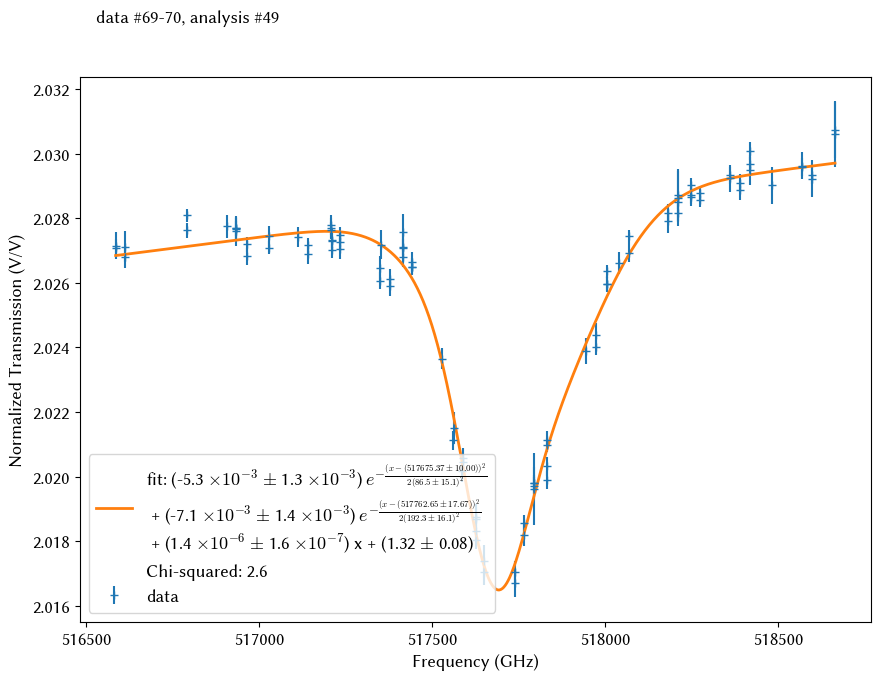

In [1148]:
p0 = [-0.00549, 517689, 76, -0.0149, 517595.8, 160, 0.001, 0]
# p0 = [-0.0649, 517595.8, 160, 0.001, 0]

fit_function = double_gaussian_lin
x = frequency_GHz
y = V_ratio
yerr = V_ratio_err

# def plot_fit():

popt, pcov = curve_fit(fit_function, x, y, p0=p0)
fit_params = popt
# if the data includes y error bars in an array 'yerr', you can calculate the reduced chi-squared to quantify the goodness of the fit
residuals = y - fit_function(x, *popt)
wssr = np.sum(residuals ** 2 / yerr ** 2)  # weighted sum of squares of residuals
ndof = len(y) - len(popt)  # number of degrees of freedom
chi_squared = wssr / ndof  # definition of chi_squared (reduced)
print(chi_squared)
print("Fit parameters", end='\n\n')
for i in range(len(popt)):
    print(f"\t {popt[i]} \t +/- {np.sqrt(pcov[i, i]) * np.sqrt(chi_squared)}")
# plot
tnew = np.linspace(x.min(), x.max(),
                   1000)  # denser coverage along x-axis to get a smoother fit line

fig, ax = plt.subplots(1, 1, figsize=(9, 7))

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Libertinus Sans']})  # alternative: 'Linux Biolinum O'
plt.rcParams['font.size'] = 13
plt.rcParams['mathtext.fontset'] = 'cm'  # use Computer Modern for math

ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Normalized Transmission (V/V)")
ax.errorbar(x, y, yerr, marker='+', label="data", ls="none")

fit_label = generate_fit_label(fit_function, popt, pcov, chi_squared)
ax.plot(tnew, fit_function(tnew, *popt), lw=2, label=fit_label)

plt.plot([], [], ' ', label=f"Chi-squared: {chi_squared:.1f}")
plt.legend()
add_label(ax)
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_transmission_fitting.pdf")
)
plt.show()

### Plot underlying functions

## Optical depth

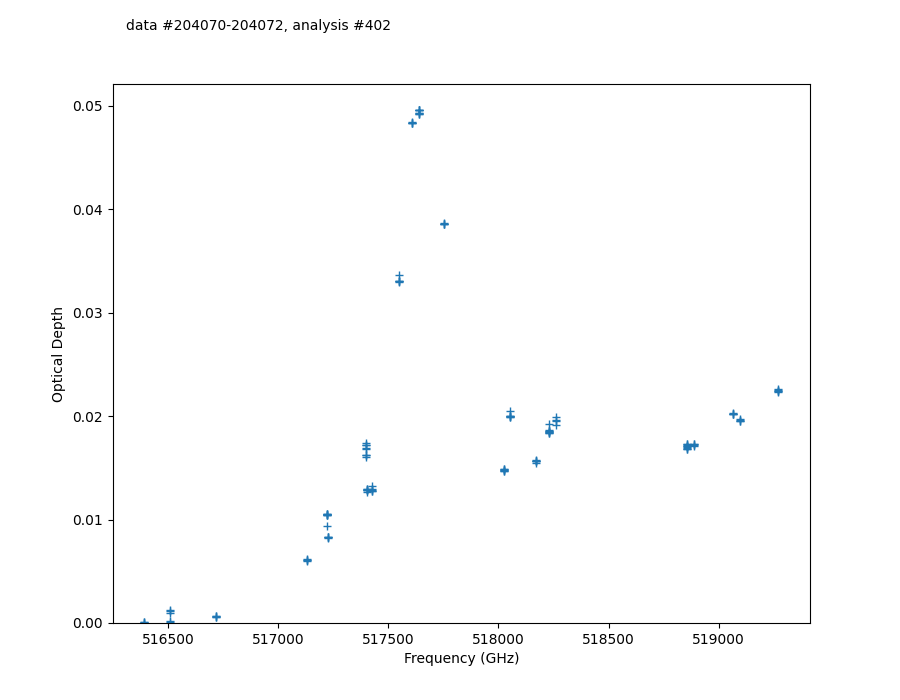

In [11]:
normalization = np.max(V_ratio)
transmission_norm = V_ratio/normalization
normalized_transmission_errs = V_ratio_err/normalization

y = -np.log(np.array(transmission_norm))
yerr = normalized_transmission_errs/transmission_norm


# plt.scatter(frequency_GHz, y, marker="+")
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
plt.errorbar(frequency_GHz, y, yerr, marker='+', ls="none")

plt.xlabel("Frequency (GHz)")
plt.ylabel("Optical Depth")
plt.ylim(0, )
add_label(ax)
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_absorption_optical_depth.pdf")
)
plt.show()

## Fitting Optical Depth

2.578004307861396
Fit parameters

	 0.0026465076585057193 	 +/- 0.0006638012613684028
	 517675.4192081161 	 +/- 9.966536360231347
	 86.45475123644644 	 +/- 15.03741778489954
	 0.003504577477036114 	 +/- 0.0006753961609459445
	 517762.5879736216 	 +/- 17.64376509517916
	 192.1235758201008 	 +/- 16.05740144042882
	 -6.787887229641929e-07 	 +/- 7.708819932112205e-08
	 0.35256938652319686 	 +/- 0.03989700101159753


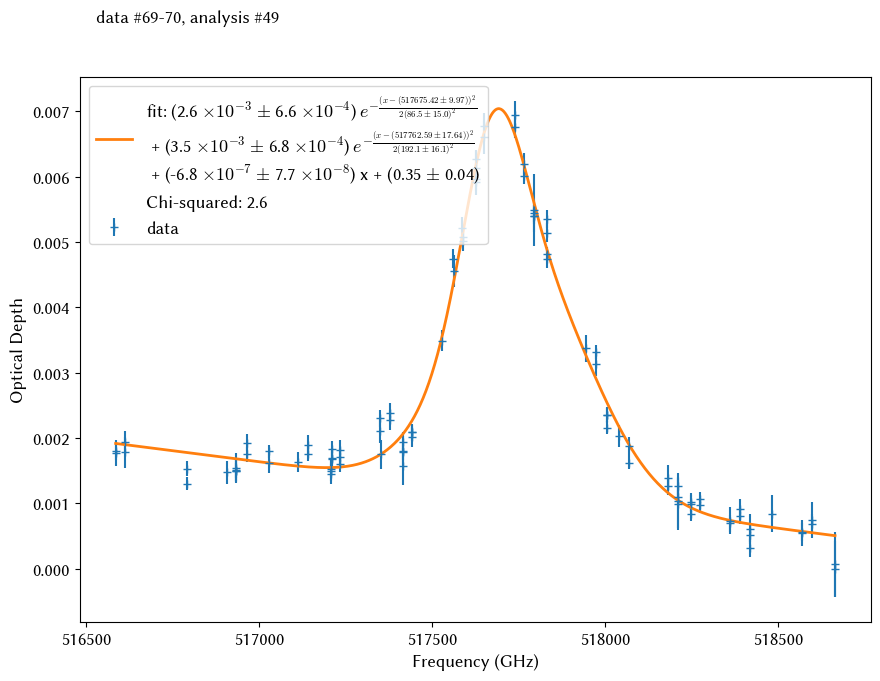

In [1151]:
p0 = [0.012, 517595.8, 76, 0.025, 517689, 160, 0.01, 0]
fit_function = double_gaussian_lin

popt, pcov = curve_fit(fit_function, frequency_GHz, y, p0=p0)
fit_params = popt
# # if the data includes y error bars in an array 'yerr', you can calculate the reduced chi-squared to quantify the goodness of the fit
residuals = y - fit_function(frequency_GHz, *popt)
wssr = np.sum(residuals ** 2 / yerr ** 2)  # weighted sum of squares of residuals
ndof = len(y) - len(popt)  # number of degrees of freedom
chi_squared = wssr / ndof  # definition of chi_squared (reduced)
print(chi_squared)
# delta_a_1, delta_x0_1, delta_sigma_1, delta_a_2, delta_x0_2, delta_sigma_2, delta_a_3, delta_x0_3, delta_sigma_3, delta_H = [
#     np.sqrt(pcov[i, i]) * np.sqrt(chi_squared) for i in
#     range(len(popt))]
print("Fit parameters", end='\n\n')
for i in range(len(popt)):
    print(f"\t {popt[i]} \t +/- {np.sqrt(pcov[i, i]) * np.sqrt(chi_squared)}")
# plot
tnew = np.linspace(frequency_GHz.min(), frequency_GHz.max(),
                   1000)  # denser coverage along x-axis to get a smoother fit line

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Libertinus Sans']})  # alternative: 'Linux Biolinum O'
plt.rcParams['font.size'] = 13
plt.rcParams['mathtext.fontset'] = 'cm'  # use Computer Modern for math

ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Optical Depth")
ax.errorbar(frequency_GHz, y, yerr, marker='+', label="data", ls="none")

fit_label = generate_fit_label(fit_function, popt, pcov, chi_squared)
ax.plot(tnew, fit_function(tnew, *popt), lw=2, label=fit_label), 

plt.plot([], [], ' ', label=f"Chi-squared: {chi_squared:.1f}")
plt.legend()
# plt.title(f"{desc}")
# plt.xlim(start, end)
add_label(ax)
# plt.subplots_adjust(left=0.08, bottom=0.1, right=0.97, top=0.95)
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_absorption_optical_depth_fitting.pdf")
)
plt.show()